# Plotting Multiple Curves in Python

A common challenge in data analytics is: easily plotting multiple curves
on the same graph.

In `Python` the `seaborn` `lineplot` function supplies an excellent way to do
this, but the data often has to be transformed prior to plotting. In this note
we will show how to do this in a way that is easy to document.

First let's import our packages and set up our example data.



In [1]:
import pandas
import seaborn
import data_algebra.cdata

In [2]:
effect_curve = pandas.read_csv('effect_curve.csv')
effect_curve

,n,n_A,n_B,T,E,T+E
0,10000,9000.0,1000.0,0.005455,0.002913,0.008368
1,23778,21400.2,2377.8,0.003538,0.001889,0.005427
2,37556,33800.4,3755.6,0.002815,0.001503,0.004318
3,51335,46201.5,5133.5,0.002408,0.001286,0.003693
4,65113,58601.7,6511.3,0.002138,0.001142,0.003279
...,...,...,...,...,...,...
99,1346504,1211853.6,134650.4,0.000470,0.000251,0.000721
100,1360282,1224253.8,136028.2,0.000468,0.000250,0.000717
101,1374059,1236653.1,137405.9,0.000465,0.000248,0.000714
102,1374060,1236654.0,137406.0,0.000465,0.000248,0.000714


The above is a data frame of an A/B test plan as a function of the test size `n`.

The exact meaning of the columns is in the domain of A/B tests, something we skip over here.

However, to name the columns we have: each row contains the target number
of examples to send to `A` and `B`: `n_a` and `n_b` respectively (can be fractional). Also present are `T` the decision threshold as a difference of conversion rates at the desired significance, and `E` how far above the decision threshold the test is achieving the desired test power.

What our in-domain task is: plot `T` and `T+E` as functions of `n` on a nice looking graph with a legend.

An easy way to do this is with `seaborn`. However, for this task `seaborn` does not want each fact that
is a function of `n` in a single row, it wants each fact in a separate row. That is it wants the table in
a somewhat different format.

Now there a are *lots* of ways to switch formats (`pandas.melt` being the most relevant). However I want
to show a simple way that well documents intent and is part of a larger system that supports arbitrary record
transformations both in `Pandas` and in `SQL`. In such a system you never run out of steam.

The key to this system is taking the time to write down one example record you have and one example record you want.

The example record we have is:

In [3]:
# input form
example_input = effect_curve.loc[effect_curve.n == 10000, :]
example_input

,n,n_A,n_B,T,E,T+E
0,10000,9000.0,1000.0,0.005455,0.002913,0.008368


For plotting we want this record to look like this:

In [4]:
# output form
example_output = pandas.DataFrame({
    'n': [10000, 10000],
    'curve': ['T', 'T+E'],
    'effect size': [0.005455, 0.008368]
})

example_output

,n,curve,effect size
0,10000,T,0.005455
1,10000,T+E,0.008368


That is, we want a record that spans multiple rows that picks up a set of the columns of the original record.

Our suggested way to achieve this transform is as follows. Look at the input and output and name some of the components
as follows.

  * Examine the input "row record format" example to identify what set of columns are the row record keys,
    or uniquely identify rows.
    In our case row record keys  are `['n']`. Values in this set of columns tell us what record we are referring to.
  * Examine the input "row record format" example to identify columns we want values from.
    In this example we want the columns `['T', 'T+E']`. We will call these the
    "record value columns". What set of columns one wants is an application or domain decision.
  * Examine the output "block record format" to identify the column that is the attribute key column.
    The attribute key tells us what portion of the original row record we are referring to.
    In this example it is the column `'curve'`. It is identifiable as the values it takes on are
    exactly the record value columns.
  * Examine the output "block record format" to identify the column that is the attribute value column.
    The attribute value column is the value associate with the record key plus attribute key. In our
    case it is the column `'effect size'`. We can identify it as it matches the values in the input
    row record.

The is a realization of Codd's rule of access: how scalar values are organized is irrelevant once we
have an abstraction of the keying.

All we have to do to realize the transform is record the above observations in an object. Let's do that now.


In [5]:
pivot = data_algebra.cdata.pivot_rowrecs_to_blocks(
    attribute_key_column='curve',
    attribute_value_column='effect size',
    record_keys = ['n'],
    record_value_columns = ['T', 'T+E'])

Now that we have our pivot object we can use it to realize the transform.

In [6]:
plot_frame = pivot.transform(effect_curve)

plot_frame.loc[plot_frame.n == 10000, :]

,n,curve,effect size
0,10000,T,0.005455
1,10000,T+E,0.008368


Notice the transform exactly realizes our desired record format. The point is: this transform is being applied to all
rows, not just the example we are looking at.

Now that we have done the work, let's make the plot.

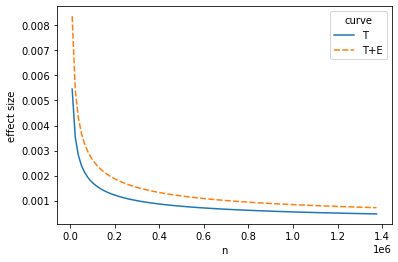

In [7]:
ax = seaborn.lineplot(
    data=plot_frame,
    x='n', y='effect size',
    hue='curve', style='curve')

And we are done.

A neat side-feature of the transform is: it is pretty much invertible. For fun let's look at that.

In [8]:
pivot

data_algebra.cdata.RecordMap(
    blocks_in=None,
    blocks_out=data_algebra.cdata.RecordSpecification(
    record_keys=['n'],
    control_table=pandas.DataFrame({
    'curve': ['T', 'T+E'],
    'effect size': ['T', 'T+E'],
    }),
    control_table_keys=['curve']))

In [9]:
inv_pivot = pivot.inverse()

inv_pivot

data_algebra.cdata.RecordMap(
    blocks_in=data_algebra.cdata.RecordSpecification(
    record_keys=['n'],
    control_table=pandas.DataFrame({
    'curve': ['T', 'T+E'],
    'effect size': ['T', 'T+E'],
    }),
    control_table_keys=['curve']),
    blocks_out=None)

Notice the `blocks_in` and `blocks_out` reversed roles when we took the inverse. Let's see what the inverse does.

In [10]:
example_output

,n,curve,effect size
0,10000,T,0.005455
1,10000,T+E,0.008368


In [11]:
inv_pivot.transform(example_output)

,n,T,T+E
0,10000,0.005455,0.008368


The inverse has re-assembled the columns that were present into essentially the original format.

And that is "the entire theory" of record transformation:

  * Draw one example input and output record.
  * Systematically identify the record and attribute keys.
  * Copy this specification into a `RecordMap` data structure using `data_algebra.cdata.pivot_rowrecs_to_blocks()`
    or `data_algebra.cdata.pivot_blocks_to_rowrecs()`.
  * Apply the transform as you wish.

Some follow-up links:

  * The `Python` `data_algebra` package that supplies the `cdata` implementation: [https://github.com/WinVector/data_algebra](https://github.com/WinVector/data_algebra).
  * Some examples: [https://github.com/WinVector/data_algebra/tree/main/Examples/cdata](https://github.com/WinVector/data_algebra/tree/main/Examples/cdata) (including this example [here](https://github.com/WinVector/data_algebra/blob/main/Examples/cdata/plotting_multiple_curves_in_seaborn.ipynb)).
  * The `R` version of the package: [https://github.com/WinVector/cdata](https://github.com/WinVector/cdata) (where
    we did a lot of the original research).
  * A tutorial video on the "coordinatized data" methodology (in `R`, but the concepts carry over): [https://youtu.be/4cYbP3kbc0k](https://youtu.be/4cYbP3kbc0k).
